In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as py
import warnings
warnings.filterwarnings('ignore')

<h1>Insight</h1>
<h2>here i used Explored dataset result from fifa classification so here i will just do
    some feature distribution and correlation which is match for clustering K_Means
</h2>

In [2]:
df = pd.read_csv('Explored_Dataset.csv')
df.head()

,Unnamed: 0,sofifa_id,height_cm,weight_kg,player_positions,weak_foot,work_rate,body_type,attacking_finishing,attacking_heading_accuracy,...,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_sliding_tackle,F,Mid,D,Gk
0,56,207865,183,75,2,3,Medium/High,Normal,33,84,...,86,59,68,47,86,87,67.5,75.615385,84.285714,9.4
1,58,199556,165,60,2,4,Medium/High,Normal,60,55,...,84,71,87,64,95,83,76.0,84.538462,81.000000,12.8
2,65,180206,178,72,2,4,Medium/Medium,Normal,56,60,...,78,68,88,79,86,70,77.5,83.846154,78.857143,8.4
3,99,170890,180,75,2,2,Medium/High,Lean,60,68,...,86,72,74,56,82,86,76.0,80.692308,84.571429,9.6
4,103,191043,180,80,2,3,High/Medium,Normal,55,76,...,82,70,70,60,82,84,77.0,80.230769,85.142857,8.0


In [3]:
df = df[0:500]

In [4]:
# Check for categorical and numerical data so we can convert them.
print('Sum of Numerical Columns: ', len(df.select_dtypes(exclude=object).columns))
print('Sum of Categorical Columns: ', len(df.select_dtypes(include=object).columns))

Sum of Numerical Columns:  26
Sum of Categorical Columns:  2


In [5]:
def handle_categorical(df):
    
    # handling non-numerical data: must convert.
    columns = df.columns.values

    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        #print(column,df[column].dtype)
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            
            column_contents = df[column].values.tolist()
            #finding just the uniques
            unique_elements = set(column_contents)
            # great, found them. 
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    # creating dict that contains new
                    # id per unique string
                    text_digit_vals[unique] = x
                    x+=1
            # now we map the new "id" vlaue
            # to replace the string. 
            df[column] = list(map(convert_to_int,df[column]))

    return df

In [6]:
# We Convert them here the categorical
df = handle_categorical(df)

In [7]:
# let's choose heigh_cm for clustering and see the correlation percentage
df.corr().abs()['movement_balance'].sort_values(ascending=False)

movement_balance              1.000000
height_cm                     0.826892
weight_kg                     0.659256
attacking_heading_accuracy    0.549708
skill_dribbling               0.458475
Mid                           0.416693
F                             0.366443
mentality_positioning         0.335356
mentality_vision              0.286803
attacking_volleys             0.274878
attacking_finishing           0.268555
power_stamina                 0.251707
mentality_interceptions       0.193052
mentality_aggression          0.190369
power_long_shots              0.189675
defending_sliding_tackle      0.182003
mentality_penalties           0.161374
movement_reactions            0.109925
work_rate                     0.104322
D                             0.097401
weak_foot                     0.075934
mentality_composure           0.059749
skill_long_passing            0.048339
Gk                            0.025398
body_type                     0.024952
sofifa_id                

Text(0.5, 1.05, 'Correlation Matrix')

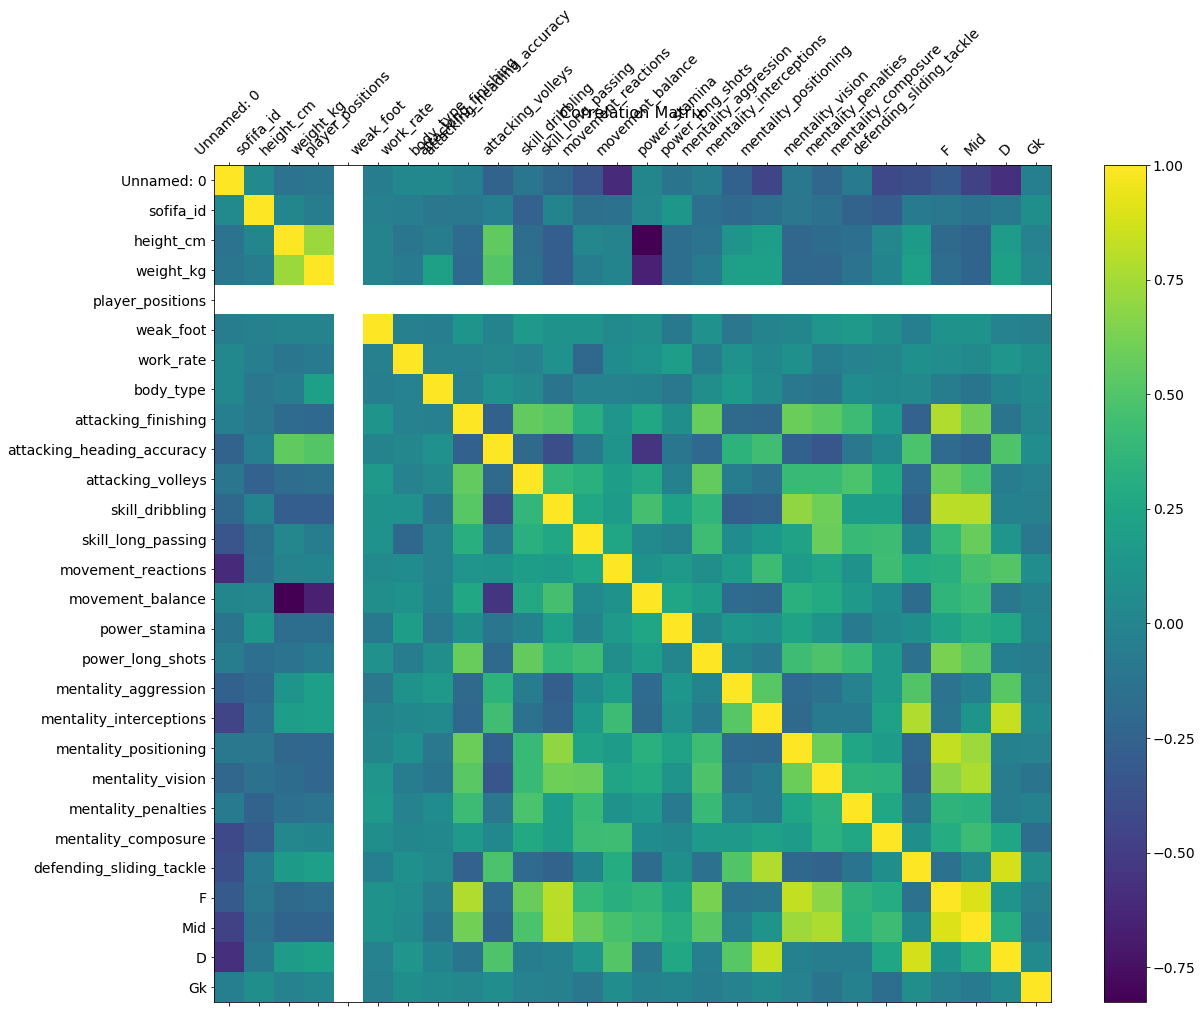

In [8]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
#Below is the correlation in matrix form to see correlation with good insight for height_cm and
# we see that movement_balanced and weight_kg is qualified as a versus for height_cm

<h2>We will use mentality composure feature for clustering, the intuition is we will cluster player with certain height and movement_balanced</h2>
<h2> Lets see the below distribution</h2>

In [9]:
fig = tools.make_subplots(rows=1, cols=2)

height = go.Histogram(x=df['attacking_heading_accuracy'], nbinsx=25, opacity=0.7, name='attacking accuracy')
move = go.Histogram(x=df['movement_balance'], nbinsx=30, opacity=0.7, name='movement balance')

fig.append_trace(height, 1,1)
fig.append_trace(move, 1,2)

fig['layout'].update(title='<b>Height & Movement Distribution</b>', \
                     xaxis=dict(automargin=True),
                     yaxis=dict(title='<b><i>Count</b></i>')
                    )
py.iplot(fig)
# we can see the histogram down below that most player in range 170 cm to 195 cm
# in weight we can see the distribution mostly within 60 kg to 90 kg

In [10]:
#get the features for clusters
data_clust = df[['attacking_heading_accuracy', 'movement_balance']]

<h1> I only use 500 data from our dataset that has 25k++ rows because if i use a lot of data, my computer is not
    strong enough to run it, sorry<h2>

<img src="sad.png" style="width: 400px;" align="center">

In [11]:
dataset = data_clust.astype(float).values.tolist()
X = data_clust.values
X.shape

(500, 2)

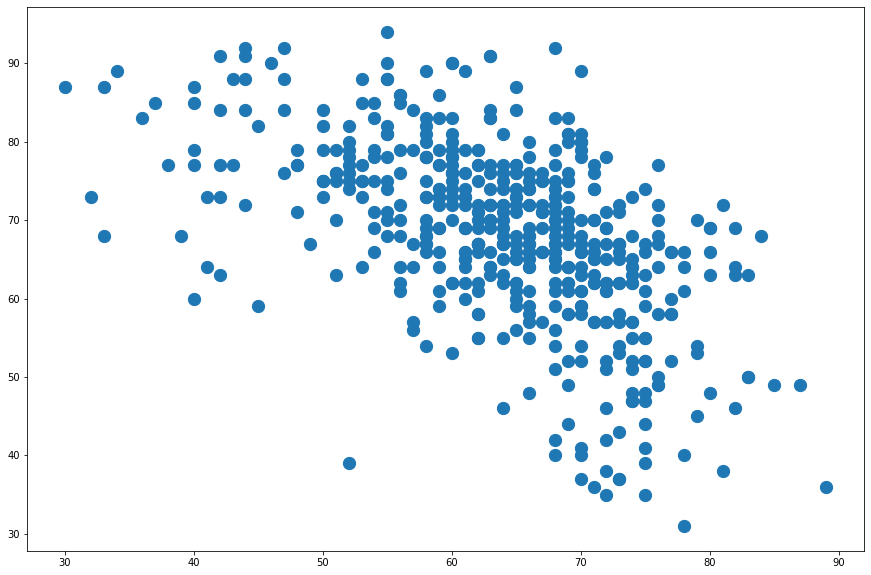

In [12]:
plt.figure(figsize=(15,10))
plt.scatter(X[:,0], X[:,1], s=150)

In [13]:
#Here we use K-Means Algorithm
# It should be obvious where our clusters are. We're going to be choosing K=5. We will begin building our K Means class
class K_Means:
    def __init__(self, k, tolerance=0.001, n_iter=300):
        self.k = k
        self.tolerance = tolerance
        self.n_iter = n_iter
#     We just set up some starting values here, k is ...well... k. The tolerance value is our tolerance,
#     which will allow us to say we're optimized if the centroid is not moving more than the tolerance value.
#     The n_iter value is to limit the number of cycles we're willing to run.
    def fit(self,data):
#     To begin, we know we just need to pass whatever data we're fitting to. We then begin an empty dictionary, 
#     which will soon house our centroids. 
#     Next, we begin a for loop which simply assigns our starting centroids as the first two data samples in our data.
#     If you wanted to truly select randomly the starting centroids, you could first shuffle the data, but this should be fine.
        self.centroids = {}
        sse = []
        for i in range(self.k):
            self.centroids[i] = data[i]

        for i in range(self.n_iter):
            self.classify = {}
#         Now we begin iterating through our max_iter value(above code). While here, 
#         we start with empty classifications, and then create two dict keys (by iterating through range of self.k)
            for i in range(self.k):
                self.classify[i] = []
#         Next, we need to iterate through our features, calculate distances of the features to the current centroids, 
#         and classify them as such below.
            for set_of_feature in data:
#             using euclidean with this prediction function as EVALUATION
                distances = [np.linalg.norm(set_of_feature-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                sse.append(classification)
                self.classify[classification].append(set_of_feature)

           
#             Next, we're going to need to create the new centroids, as well as measuring the movement of the centroids.
#             If that movement is less than our tolerance (self.tol), then we're all set.
#             Including that addition, full code up to this point
            
            prev_centroids = dict(self.centroids)

            for classification in self.classify:
                self.centroids[classification] = np.average(self.classify[classification],axis=0)
#           here will check if the centroid to optimized it
            IsOptimized = True
#             We start off assuming we are optimized. 
#             We then take all of the centroids, and compare them to the previous centroids.
#             If they are within our required tolerance, then we're happy. 
#             If not, then we set optimized to False and we continue in our for for i in range(self.n_iter): loop. 
#             If we are optimized?


            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tolerance:
                    print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    IsOptimized = False
#       if it's optimized then move to another centroid
            if IsOptimized:
                break
        print('calculated euclidean dist :', np.sum(sse))
        print('calculated euclidean dist avg :', np.sum(sse)/len(sse))
    #compare distance to either centroid 
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification


# The above prediction function in K_Means class is to evaluate using euclidean distance

In [14]:
# we are performing scaling to make range of balanced value between x and y axis
from sklearn.preprocessing import scale
classifier = K_Means(5)
X = scale(X)
classifier.fit(X)

7907.345068193639
68.04370413866057
57.06790723892277
11.373612980164548
11.467759882792196
119.68339564611443
0.685890835892228
3.019081565255842
21.208898611136078
53.95700282776276
5.944046059079354
2.394740982441503
9.65860982370073
24.705187366095362
6.406508137002831
18.668688090538275
1.9097896004425285
8.59024009875182
9.73575989876819
2.1627220639119122
7.05606025180321
0.32924239731082183
5.429072364958962
0.9469568957285888
0.6828955988753392
0.7676113687635109
0.28405704961571643
1.0834967471363768
0.6076415865255819
2.1895575635009266
1.518693572312819
calculated euclidean dist : 13053
calculated euclidean dist avg : 2.3732727272727274


In [15]:
color = 100*["g","r","c","b","k", "purple", "orchid"]
colour = 100*["g","r","c","b","k", "purple", "orchid"]

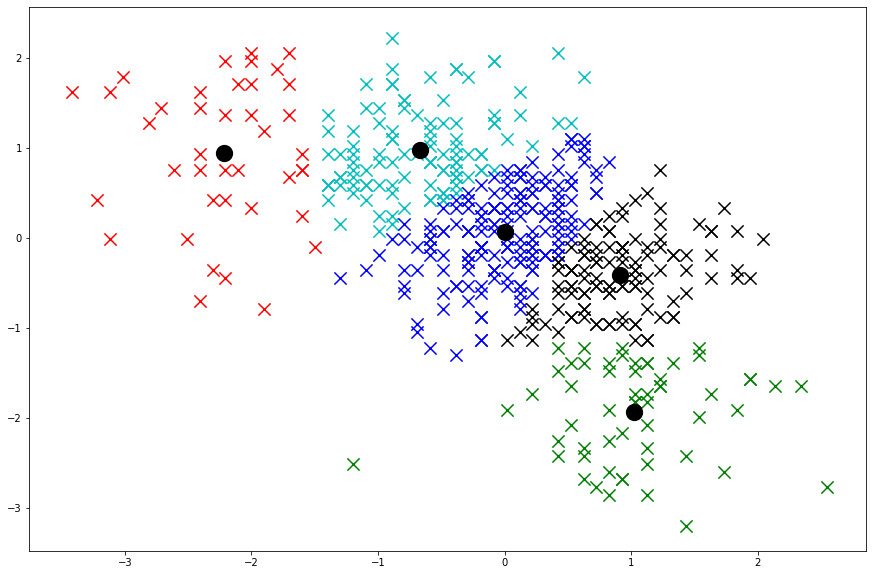

In [16]:
plt.figure(figsize=(15, 10))

# here we classify our features based on number of cluster/K
# inside the feature set that we have here
for classification in classifier.classify:
    color = colour[classification]
    for set_of_feature in classifier.classify[classification]:
        plt.scatter(set_of_feature[0], set_of_feature[1], marker="x", color=color, s=150, linewidths=5)
        
#Plotting all centroid that alredy calculated       
for centroid in classifier.centroids:
    plt.scatter(classifier.centroids[centroid][0], classifier.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

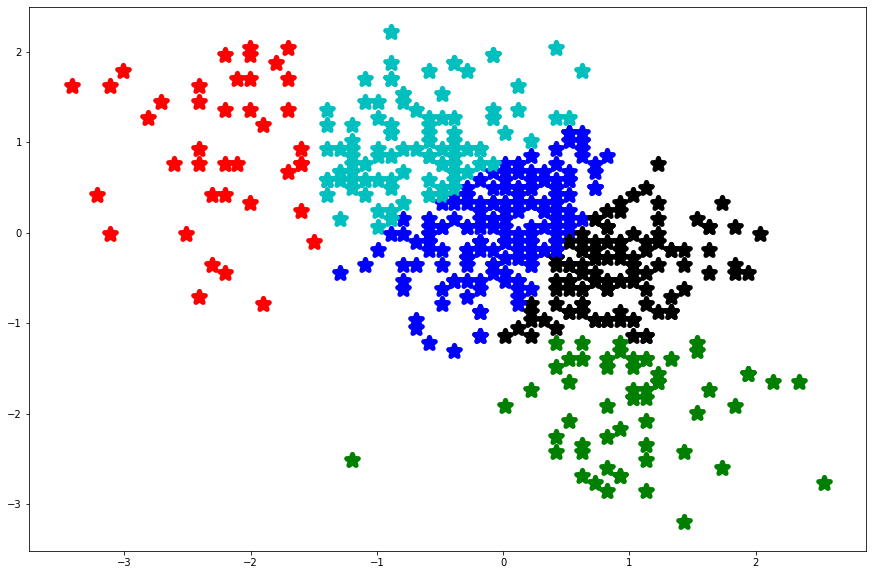

In [17]:
plt.figure(figsize=(15, 10))
new_features = []
for x in X:
    classification = classifier.predict(x)
    plt.scatter(x[0], x[1], marker="*", color=colour[classification], s=150, linewidths=5)
    new_features.append(x)


plt.show()

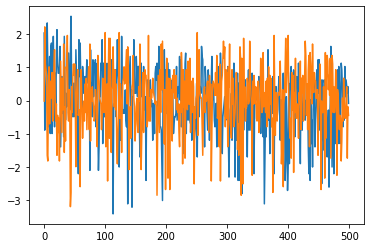

In [18]:
plt.plot(new_features)

In [20]:
import numpy as np # Import the necessary packages.
import pandas as pd 

epsilon = list(range(4)) # Initialisation of epsilon which would store cost function for each value of 'k' after final iteration.

for k in range(2,6): # Number of clusters
    
     # Read data file into 'cluster'
    data_clust = df[['height_cm', 'movement_balance']]
    
    rows = data_clust.shape[0] # 'rows' contains the total number of rows in cluster data.
    cols = data_clust.shape[1] # 'cols' contains the total number of columns in cluster data.
  
    centroids = data_clust.loc[np.random.randint(1,rows+1,k)] # Randomly initialises 'k' no. of centroids.
    centroids['new'] = list(range(1,k+1)) # New indices 1 to k are set for the dataframe 'centroids'.
    centroids.set_index('new',inplace = True) 
    d = np.random.rand(rows) # Initialization of 'd' which would contain the centroid number closest to data point.

    number_of_iterations = 15
    temp_epsilon = list(range(number_of_iterations)) # 'temp_epsilon' is the sum of squares of distances between points and centroid of a cluster for each iteration.

    for i in range(0,number_of_iterations): # This 'for' loop is for iterations.

        for j in range(0,rows): # This 'for' loop finds the centroid number closest to the data point.
            d[j] = ((centroids - data_clust.loc[j])**2).sum(axis = 1).idxmin()
        data_clust['centroid number'] = d # A new column 'centroid number' is added to dataframe 'cluster'.

        mean_x = list(range(k)) # Initialisation of 'mean_x' which will store mean of 'x' values of each cluster.
        mean_y = list(range(k)) # Initialisation of 'mean_y' which will store mean of 'y' values of each cluster.
        for m in range(0,k): # This 'for' loop calculates mean of 'x' and 'y' values of each cluster.
            mean_x[m] = data_clust[data_clust['centroid number'] == (m+1)]['height_cm'].mean()
            mean_y[m] = data_clust[data_clust['centroid number'] == (m+1)]['movement_balance'].mean()
        centroids.replace(list(centroids['height_cm']),mean_x,inplace = True) # The 'centroids' are replaced with the new values.
        centroids.replace(list(centroids['movement_balance']),mean_y,inplace = True)
    
        z = list(range(k)) # Initialisation of z  and centroid of each cluster.
        for p in range(0,k): # This 'for' loop calculates square of distances between data points and centroid of each cluster.
            z[p] = ((data_clust[data_clust['centroid number'] == p+1][['height_cm','movement_balance']] - centroids.iloc[p])**2).values.sum()
        temp_epsilon[i] = sum(z) 
        
        epsilon[k-2] = temp_epsilon[i] # The cost function after final iteration for each value of 'k' would be stored in epsilon.
    
    %reset_selective -f centroids # The dataframe 'centroids' is reset.

Text(0, 0.5, 'Value of Epsilon')

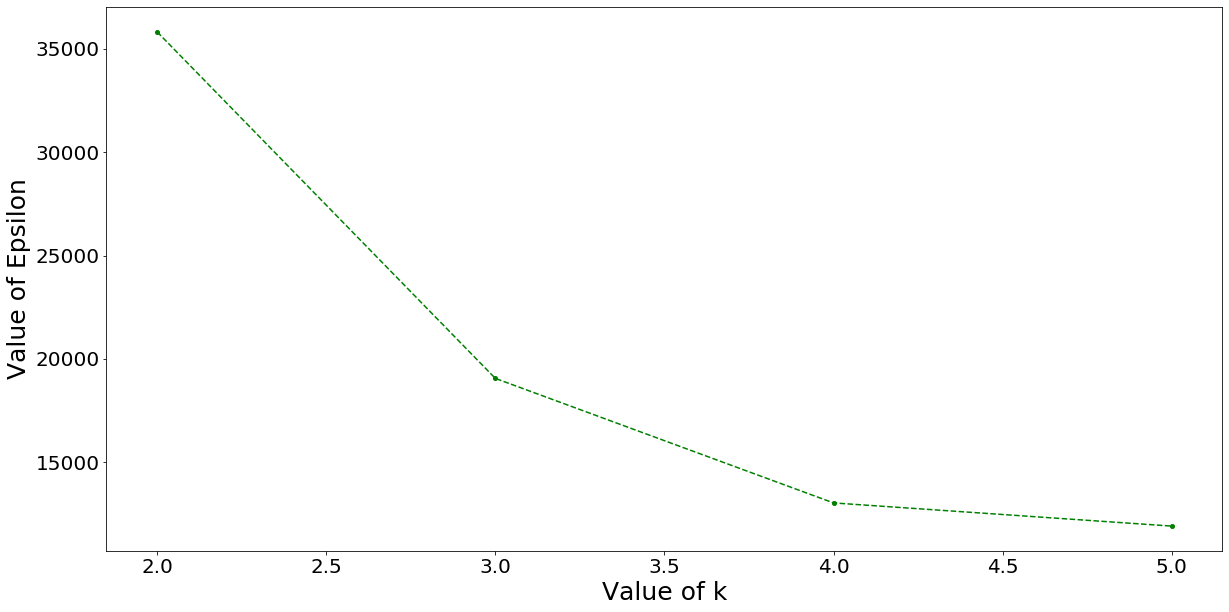

In [21]:
k = list(range(2,6)) # Range of 'k'
plt.figure(figsize=(20,10)) # Size of figure is adjusted.
plt.xticks(fontsize=20) # Size of number labels on x-axis is adjusted.
plt.yticks(fontsize=20) # Size of number labels on y-axis is adjusted.
plt.plot(k,epsilon,'go--', linewidth=1.5, markersize=4) # Graph is plotted.
plt.xlabel('Value of k',fontsize = 25) # x-axis is labelled.
plt.ylabel('Value of Epsilon',fontsize = 25) # y-axis is labelled.

In [22]:
classifier = K_Means(4)
classifier.fit(X)

7066.088426768678
68.04370413866057
57.06790723892277
4.081945419576707
6.334972682126457
32.26359276085489
3.330113900228313
0.020186373702982152
4.531603101210717
7.525584812575506
4.043041764101817
6.675446221118767
2.121944759864845
1.5856475507389307
2.1870120799824315
153.34367415376747
3.472223588679599
31.650086384381126
2.1117794496169626
26.237736710015806
4.930995388387371
30.67167404888274
2.4621684888070883
22.33860303477078
1.9359958394140087
15.059404237105179
1.8841194765457219
18.88114243407938
2.2967276382892234
19.762933748928855
4.663371169036992
18.97752914127606
2.003276502534779
14.218025082077212
0.8863971843759179
1.698537688577832
0.5276400583692522
9.806635366916082
1.5673640735998247
9.774498274579916
0.8285705005322155
4.740127328793713
1.6044106611964377
3.7598072414585717
1.5017977016605062
1.1873893727302327
1.333834614910915
2.095400972308292
5.341316237519378
3.0756547439891357
4.479397040626669
3.3861399743830605
2.96435262056122
calculated euclidean 

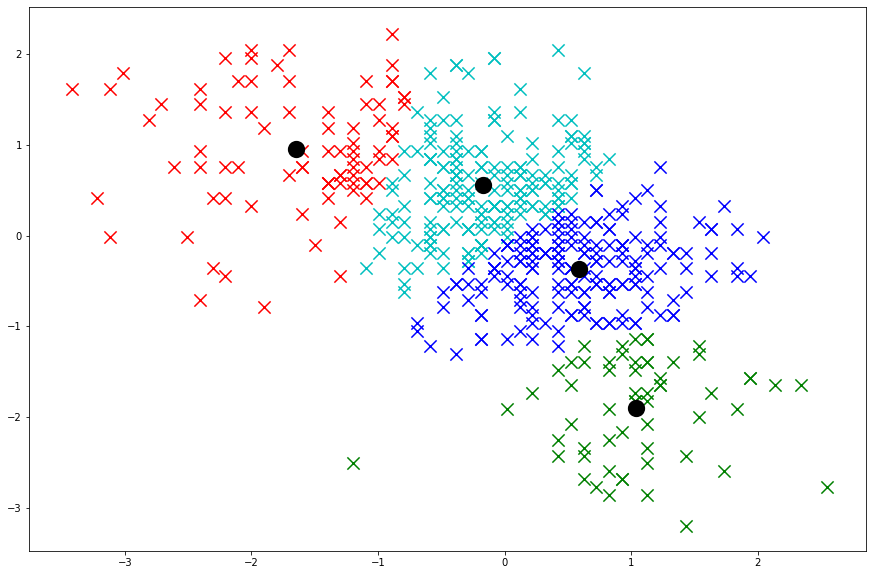

In [24]:
plt.figure(figsize=(15, 10))

# here we classify our features based on number of cluster/K
# inside the feature set that we have here
for classification in classifier.classify:
    color = colour[classification]
    for set_of_feature in classifier.classify[classification]:
        plt.scatter(set_of_feature[0], set_of_feature[1], marker="x", color=color, s=150, linewidths=5)
        
#Plotting all centroid that alredy calculated       
for centroid in classifier.centroids:
    plt.scatter(classifier.centroids[centroid][0], classifier.centroids[centroid][1],
                marker="o", color="k", s=150, linewidths=5)

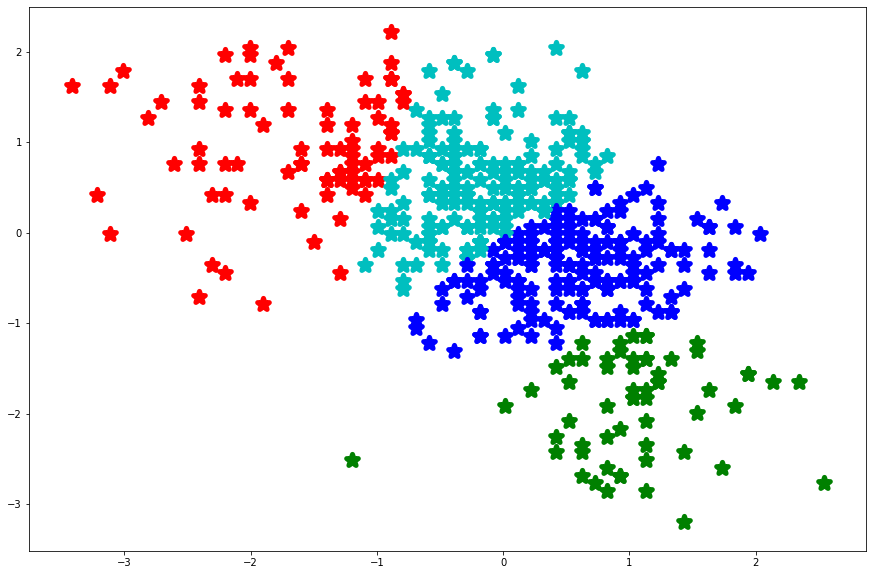

In [25]:
plt.figure(figsize=(15, 10))
new_features = []
for x in X:
    classification = classifier.predict(x)
    plt.scatter(x[0], x[1], marker="*", color=colour[classification], s=150, linewidths=5)
    new_features.append(x)


plt.show()